In [63]:
import numpy as np
import networkx as nx
import math
import random
import time
import tracemalloc

In [ ]:
class Infomap():
    
    def __init__(self, G, weight):
        """
        Initializes the Infomap and extracts lists of nodes and edges from a NetworkX graph along with the size of the graph.
    
        Args:
            G: NetworkX graph
            weight: Boolean indicating if the graph is weighted
        """
        self.G = G
        self.weight = bool(weight)
        self.nodes = list(self.G.nodes())
        self.edges = list(self.G.edges())
        self.sz = len(self.nodes)

    
    def get_edge_weights(self):
        """
        Get the total edge weights for a graph.
    
        Args:
            self: Infomap
    
        Returns:
            If the graph is unweighted, return the number of edges.
            If the graph is weighted, return the sum of the edge weights.
        """
        if self.weight == True:
            total_weight = 0.0
            for i, j, k in self.G.edges(data=True):
                total_weight += float(k.get("weight", 1.0))
            return total_weight
        else:
            return float(self.G.number_of_edges())

    
    def get_stationary_probability(self):
        """
        Get the stationary probabilities of a graph: fraction of time spent at each node on a random walk
    
        Args:
            self: Infomap
    
        Returns:
            If the graph is unweighted return a list of probabilities where pi[n] = degree[n] / (2m)
            (number of edges connected to n divided by two times total number of edges)
            
            If the graph is weighted return a list of probabilities where pi[n] = strength[n] / (2w) 
            (sum of edge weights connected to n divided by two times total edge weights)
        """
        total = self.get_edge_weights()  # m or w
        probabilities = {}
    
        # if there are no edges return 0
        if total == 0:
            for n in self.nodes:
                probabilities[n] = 0.0
            return probabilities
    
        # if weighted
        if self.weight == True:
            strengths = dict(self.G.degree(weight="weight"))  # get dict of neighbors
            for n in self.nodes:
                s = strengths.get(n, 0.0) # get for node n and cast to float
                probabilities[n] = float(s) / (2.0 * total)
        # if unweighted
        else:
            degrees = dict(self.G.degree())  # get dict of neighbors
            for n in self.nodes:
                d = degrees.get(n, 0) # get for node n
                probabilities[n] = float(d) / (2.0 * total)
                
        return probabilities

    
    def get_exit_probabilities(self, node_communities):
        """
        Get the exit probabilities of a graph: The fraction of time that a walker is exiting a community
    
        Args:
            self: Infomap
            node_communities: A dictionary from node to community member ID
    
        Returns:
            A dictionary {community: exit_probability}, where each value represents the
            probability that a random walker leaves that community during one step of the walk.
        """
        total_weight = self.get_edge_weights()
        
        # if total weight = 0 return 0
        if total_weight == 0:
            return {c: 0.0 for c in set(node_communities.values())}
    
        q_m = {c: 0.0 for c in set(node_communities.values())}
    
        # loop over edges
        # if weighted
        if self.weight == True:
            for i, j, k in self.G.edges(data=True):
                w = float(k.get("weight", 1.0))
                # if in diff communities count it, if not, skip
                if node_communities[i] != node_communities[j]:
                    q_m[node_communities[i]] += w
                    q_m[node_communities[j]] += w
        # if unweighted
        else:
            for i, j in self.G.edges():
                # if in diff communities count it, if not, skip
                if node_communities[i] != node_communities[j]:
                    q_m[node_communities[i]] += 1.0
                    q_m[node_communities[j]] += 1.0
    
        # normalize so it sums to a prob
        for c in q_m:
            q_m[c] /= (2.0 * total_weight)
    
        return q_m

    
    def map(self, node_comms):
        """
        Build a community to nodes mapping with continuous community IDs.
    
        Args:
            self: Infomap
            node_comms: A dictionary mapping each node to its community ID.
    
        Returns:
            A dictionary {community_id: [nodes...]}
            Keys are reindexed to 0..k-1 in ascending order of the original IDs.
            Values are lists of nodes belonging to each community.
        """
        communities = {}
        for n, c in node_comms.items():
            if c not in communities:
                communities[c] = []
            communities[c].append(n)

        # fix so that community keys are in the correct order
        ordered = sorted(communities.keys())
        remap = {com: i for i, com in enumerate(ordered)}
        newindex = {remap[i]: communities[i] for i in ordered}
        
        return newindex

    
    def compute_l(self, partition):
        """
        Compute L(M): the description length for a given partition.
    
        Args:
            self: Infomap
            partition: A dictionary mapping node to community ID.
    
        Returns:
            A float equal to q↷H(Q)+i=1∑mpi↻*H(Pi), i.e., the average number of bits
            needed to describe one random step under this partition.
            Lower values indicate a better community structure.
        """
        # set initial values
        edge_weights = self.get_edge_weights()
        pi = self.get_stationary_probability()
        q_m = self.get_exit_probabilities(partition)
    
        modules = set(partition.values())
    
        # initialize variables
        q = 0.0
        H_Q = 0.0
        H_Pm = 0.0
    
        # compute q: sum q_m (The total probability that the random walker enters any of the m modules)
        for m in modules:
            q += q_m.get(m, 0.0)
    
        # compute H(Q): - sum of q_m / q * log 2 * q_m / q (The entropy of module exits)
        if q > 0.0:
            H_Q = -sum(
            (q_m[m]/q) * math.log2(q_m[m]/q)
            for m in modules
            if q_m[m] > 0.0
        )
    
        # compute H(p of m): q_m + pi[i] (the probability that the random walker visits node a or exits from module i)
        for m in modules:
            # π_i for nodes in module m (probability of visiting them)
            prob_of_visit = []
            for i in self.nodes:
                if partition[i] == m:
                    prob_of_visit.append(pi[i])

            # q_m[m] = probability of exiting module m
            prob_of_exit = q_m[m]
    
            # ṗ_m = total time spent inside + time spent exiting
            pdot = sum(prob_of_visit) + prob_of_exit
    
            if pdot > 0:
                # list of probabilities used for entropy calculation
                probs = []
    
                # add exit probability (as a fraction of ṗ_m)
                probs.append(prob_of_exit / pdot)
    
                # add visit probabilities for each node in this module
                for i, comm in partition.items():
                    if comm == m:
                        probs.append(pi[i] / pdot)
    
                # weighted entropy for this module
                # -sum(p log2 p) gives entropy; multiply by ṗ_m for weighting
                H_Pm += pdot * (-sum(p * math.log2(p) for p in probs if p > 0))

        # calculate the description length
        return q * H_Q + H_Pm

    
    def run(self, iters=10):
        """
        Run an Infomap pass to minimize L(M).
    
        Args:
            self: Infomap
            iters: Number of outer passes over all nodes.
    
        Returns:
            A tuple (retval, total_time, memory_used_kb) where:
              - retval is {community_id: [nodes...]} with IDs reindexed to 0..k-1.
              - total_time is the time for this call.
              - memory_used_kb is peak traced memory (in kilobytes) during the run.
        """       
        # start timer
        start_time = time.time()

        # start memory tracking
        tracemalloc.start()

        # build starting communities
        communities = {n: i for i, n in enumerate(self.nodes)}

        # compute initial L
        L = self.compute_l(communities)

        # number of iterations (can change as needed)
        for i in range(iters):
    
            # randomize order of nodes
            node_list = list(self.nodes)
            random.shuffle(node_list)
    
            for n in node_list:
                # get the current community of n
                current = communities[n]
    
                # find the community ids of n's neighbors
                neighbor_comms = set()
                for ni in self.G.neighbors(n):
                    neighbor_comms.add(communities[ni])
    
                # initialize tracking metrics
                current_L = L
                new_current = current
                best_L = current_L

                # move n into the community of its neighbors
                for node in neighbor_comms:
                    communities[n] = node
                    # compute new L for node
                    new_L = self.compute_l(communities)

                    # if the new description length is lower we update
                    # the best description length
                    if new_L < best_L:
                        best_L = new_L
                        new_current = node

                # if we have found a better move
                if new_current != current:
                    # move the node into that community and update L
                    communities[n] = new_current
                    L = best_L
                else:
                    communities[n] = current

        # map return values to the correct format
        retval = self.map(communities)

        # end timer
        end_time = time.time()
        total_time = end_time - start_time

        # end memory tracking
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        # convert units
        memory_used_kb = peak / 1024
        
        return retval, total_time, memory_used_kb

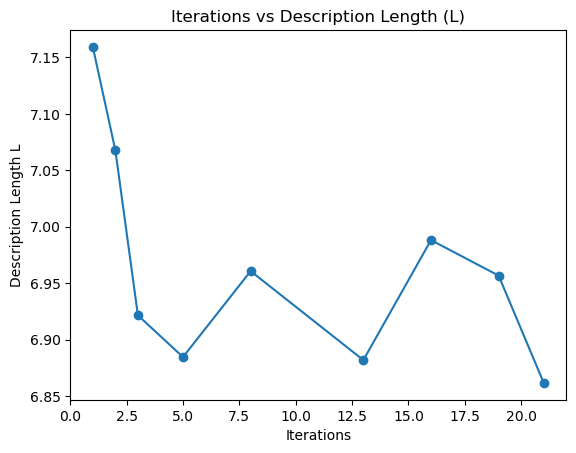

In [122]:
'''
Create a graph and test with multiple iteration values to find variations desription length
'''

G = nx.erdos_renyi_graph(n=200, p=0.02, seed=50)
weight = False

iter_values = [1, 2, 3, 5, 8, 13, 16, 19, 21]
comm_counts, L_values = [], []

for iters in iter_values:
    im = Infomap(G, weight)
    communities, elapsed, memory = im.run(iters=iters)

    partition = {}
    for c, nodes in communities.items():
        for u in nodes:
            partition[u] = c

    pi = im.get_stationary_probability()
    q_m = im.get_exit_probabilities(partition)
    L = im.compute_l(partition)

    comm_counts.append(len(communities))
    L_values.append(L)

# plot: iterations to L value
plt.figure()
plt.plot(iter_values, L_values, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Description Length L")
plt.title("Iterations vs Description Length (L)")
plt.show()

In [ ]:
'''
Create a graph and test with multiple sizes to find variations in runtime vs graph size
'''

sizes = [10, 50, 100, 200]
avg_deg = 8
weight = False

size_x, comm_y, time_y = [], [], []

for n in sizes:
    p = avg_deg / max(1, (n - 1))
    G = nx.erdos_renyi_graph(n=n, p=p, seed=100 + n)

    im = Infomap(G, weight)
    communities, elapsed, memory = im.run()

    size_x.append(n)
    time_y.append(elapsed)

# plot: size -> runtime
plt.figure()
plt.plot(size_x, time_y, marker='o')
plt.xlabel("Graph size (n)")
plt.ylabel("Runtime (s)")
plt.title("Runtime vs Graph Size")
plt.show()

In [ ]:
'''
Create a random weighted graph and build color coded community structures
'''

G = nx.erdos_renyi_graph(n=30, p=0.15, seed=42)

for u, v in G.edges():
    G[u][v]["weight"] = round(random.uniform(0.5, 5.0), 2)

im = Infomap(G, weight=True)
communities, elapsed, mem = im.run()

node_to_comm = {n: cid for cid, nodes in communities.items() for n in nodes}
pos = nx.spring_layout(G, seed=1)
node_colors = [node_to_comm[n] for n in G.nodes()]

plt.figure(figsize=(7, 7))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=node_colors,
    node_size=100,
    cmap=plt.cm.tab10,
    edge_color="lightgray",
    with_labels=False
)
plt.title("Infomap on random weighted graph")
plt.axis("off")
plt.show()

In [ ]:
'''
Create a random unweighted graph and build color coded community structures
'''

G = nx.erdos_renyi_graph(n=30, p=0.15, seed=42)

im = Infomap(G, weight=False)
communities, elapsed, mem = im.run()

node_to_comm = {n: cid for cid, nodes in communities.items() for n in nodes}
pos = nx.spring_layout(G, seed=1)
node_colors = [node_to_comm[n] for n in G.nodes()]

plt.figure(figsize=(7, 7))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=node_colors,
    node_size=100,
    cmap=plt.cm.tab10,
    edge_color="lightgray",
    with_labels=False
)
plt.title("Infomap on random unweighted graph")
plt.axis("off")
plt.show()